In [ ]:
#Para adicionar o seu google drive à instancia para adicionar o dataset que vai ser usado para o treinamento
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#Para copiar o dataset do drive para o disco da instancia (leitura/escrita no drive dura seculos)
#!cp /content/drive/MyDrive/dataset.zip dataset.zip

In [ ]:
#Para deszipar o conteudo caso ele nao esteja na instancia
#!unzip dataset.zip

In [ ]:
#Install all dependencies for sgementation-models-3D library.
#We will use this library to call 3D unet.
#Alternative, you can define your own Unet, if you have skills!
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D
!pip install scikit-image
!pip install matplotlib
!pip install scikit-learn
!pip install nibabel
!pip install patchify

^C


In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.18.0
3.3.3


In [ ]:
#Make sure the GPU is available.
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import segmentation_models_3D as sm


Segmentation Models: using `keras` framework.


In [ ]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nibabel as nib
import os
from pathlib import Path

In [ ]:
def load_and_patch_images_masks(
    images_input_dir: str,
    masks_input_dir: str, # New parameter for the masks directory
    image_marker_segment: str = "_DCE_0002_N3_zscored.nii.gz",
    mask_filename_transform: tuple = ("_DCE_0002_N3_zscored.nii.gz", ".nii.gz"),
    patch_size: tuple = (64, 64, 64),
    step_size: int = 64
) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Reads image files with a specific suffix from an images directory,
    finds their matching masks in a separate masks directory, loads them,
    checks for shape consistency, creates patches, and returns pairs of
    image and mask patches.

    Args:
        images_input_dir (str): Path to the directory containing image files.
        masks_input_dir (str): Path to the directory containing mask files.
        image_suffix (str): The suffix to identify image files (e.g., "_DCE_0002.nii.gz").
        mask_filename_transform (tuple): A tuple where the first element is the part of
                                         the image filename to be replaced, and the second
                                         is what it should be replaced with to get the
                                         mask filename.
        patch_size (tuple): The size of the patches (depth, height, width).
        step_size (int): The step size for patch extraction.

    Returns:
        list[tuple[np.ndarray, np.ndarray]]: A list of tuples, where each tuple
                                             contains (image_patches, mask_patches).
                                             Returns an empty list if no valid pairs
                                             are found or errors occur.
    """
    collected_image_patches = []
    collected_mask_patches = []

    images_dir = Path(images_input_dir)
    masks_dir = Path(masks_input_dir)

    if not images_dir.is_dir():
        print(f"Error: Images directory not found at {images_input_dir}")
        return [], []
    if not masks_dir.is_dir():
        print(f"Error: Masks directory not found at {masks_input_dir}")
        return [], []

    print(f"Scanning for images in: {images_dir.resolve()}")
    print(f"Looking for masks in: {masks_dir.resolve()}")
    print(f"Using image marker segment: '{image_marker_segment}'")

    for image_item_path in images_dir.iterdir():
        image_filename = image_item_path.name
        if image_item_path.is_file() and image_marker_segment in image_filename and image_filename.endswith(".nii.gz"):

            parts = image_filename.split(image_marker_segment)
            if not parts or len(parts[0]) == 0:
                print(f"Warning: Could not derive base name from {image_filename} using marker '{image_marker_segment}'. Skipping.")
                continue

            mask_base_name = parts[0]
            mask_file_name = f"{mask_base_name}.nii.gz"
            mask_file_path = masks_dir / mask_file_name

            if not mask_file_path.exists():
                print(f"Warning: Mask file {mask_file_path} (derived for image {image_filename}) not found. Skipping.")
                continue

            try:
                #print(f"Processing image: {image_filename}")
                image_nib = nib.load(str(image_item_path))
                image_data = image_nib.get_fdata()

                #print(f"Processing mask: {mask_file_path.name}")
                mask_nib = nib.load(str(mask_file_path))
                mask_data = mask_nib.get_fdata()

                if image_data.shape != mask_data.shape:
                    print(f"Warning: Shape mismatch for {image_filename} ({image_data.shape}) and {mask_file_path.name} ({mask_data.shape}). Skipping.")
                    continue

                print(f"Shapes match: Image={image_data.shape}, Mask={mask_data.shape}")

                if len(image_data.shape) < len(patch_size) or len(mask_data.shape) < len(patch_size):
                    print(f"Warning: Data dimension ({image_data.shape}) is less than patch dimension ({patch_size}) for {image_filename}. Skipping.")
                    continue

                img_patches = patchify(image_data, patch_size, step=step_size)
                mask_patches = patchify(mask_data, patch_size, step=step_size)

                #print(f"Generated image patches shape: {img_patches.shape}")
                #print(f"Generated mask patches shape: {mask_patches.shape}")

                collected_image_patches.append(img_patches)
                collected_mask_patches.append(mask_patches)

            except FileNotFoundError:
                print(f"Error: File not found during loading for {image_filename} or {mask_file_path.name}. Skipping.")
            except nib.filebasedimages.ImageFileError as e:
                print(f"Error loading NIfTI file for {image_filename} or {mask_file_path.name}: {e}. Skipping.")
            except Exception as e:
                print(f"An unexpected error occurred while processing {image_filename} and {mask_file_path.name}: {e}. Skipping.")

    if not collected_image_patches: # Check if any images were processed
        print("No image-mask pairs were successfully processed and patched. Returning empty lists.")

    print(f"Finished loading {len(collected_image_patches)} images and {len(collected_mask_patches)} masks")
    return collected_image_patches, collected_mask_patches

In [ ]:
#Load input images and masks.
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training.
image = nib.load('dataset/Images/ISPY1_1221_DCE_0002_N3_zscored.nii.gz').get_fdata()
print(image.shape)
img_patches = patchify(image, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap
print(img_patches.shape)
mask = nib.load('dataset/Masks/ISPY1_1221.nii.gz').get_fdata()
print(mask.shape)
mask_patches = patchify(mask, (64, 64, 64), step=64)
print(mask_patches.shape)

images_list, masks_list = load_and_patch_images_masks(
    "./dataset/Images",
    "./dataset/Masks"
)

(180, 180, 147)
(2, 2, 2, 64, 64, 64)
(180, 180, 147)
(2, 2, 2, 64, 64, 64)
Scanning for images in: /content/dataset/Images
Looking for masks in: /content/dataset/Masks
Using image marker segment: '_DCE_0002_N3_zscored.nii.gz'
Shapes match: Image=(180, 180, 155), Mask=(180, 180, 155)
Shapes match: Image=(210, 210, 120), Mask=(210, 210, 120)
Shapes match: Image=(220, 220, 120), Mask=(220, 220, 120)
Shapes match: Image=(270, 270, 120), Mask=(270, 270, 120)
Shapes match: Image=(220, 220, 156), Mask=(220, 220, 156)
Shapes match: Image=(250, 250, 138), Mask=(250, 250, 138)
Shapes match: Image=(200, 200, 132), Mask=(200, 200, 132)
Shapes match: Image=(180, 180, 128), Mask=(180, 180, 128)
Shapes match: Image=(200, 200, 138), Mask=(200, 200, 138)
Shapes match: Image=(180, 180, 90), Mask=(180, 180, 90)
Shapes match: Image=(180, 180, 128), Mask=(180, 180, 128)
Shapes match: Image=(180, 180, 160), Mask=(180, 180, 160)
Shapes match: Image=(200, 200, 128), Mask=(200, 200, 128)
Shapes match: Image=(

In [ ]:
##Load training data and masks
image_t = nib.load('dataset/Images/ISPY1_1002_DCE_0002_N3_zscored.nii.gz').get_fdata()
print(image_t.shape)
img_patches_training = patchify(image_t, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap
print(img_patches_training.shape)
mask_t = nib.load('dataset/Masks/ISPY1_1002.nii.gz').get_fdata()
print(mask_t.shape)
mask_patches_training = patchify(mask_t, (64, 64, 64), step=64)
print(mask_patches_training.shape)


(200, 200, 120)
(3, 3, 1, 64, 64, 64)
(200, 200, 120)
(3, 3, 1, 64, 64, 64)


(3, 3, 1, 64, 64, 64)


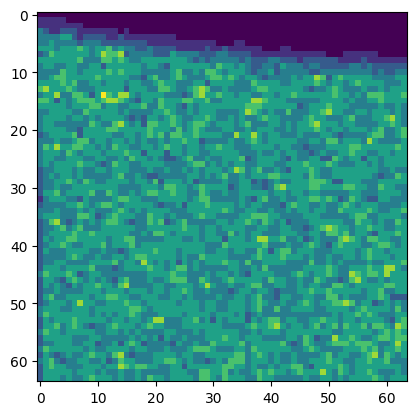

In [ ]:
plt.imshow(images_list[140][0,0,0,:,:,3])
#plt.imshow(mask_patches[0,1,2,:,:,3])
#plt.imshow(mask_patches[0,0,7,:,:,2])
print(np.shape(images_list[140]))


In [ ]:
print(len(images_list))
## Reshaping the lists
for i in range(len(images_list)):
    images_list[i] = np.reshape(images_list[i], (-1, images_list[i].shape[3], images_list[i].shape[4], images_list[i].shape[5]))
    masks_list[i] = np.reshape(masks_list[i], (-1, masks_list[i].shape[3], masks_list[i].shape[4], masks_list[i].shape[5]))


161


In [ ]:
#Concatenating it all into a single list
images_list = np.concatenate(images_list, axis=0)
masks_list = np.concatenate(masks_list, axis=0)

tumor = 0
bg = 0
for chunk in masks_list:
    tumor += np.count_nonzero(chunk==1)
    bg += np.count_nonzero(chunk==0)

print(bg,tumor)
print(f"Percentage of background: {(bg/(bg+tumor))*100}%")
print(f"Percentage of tumor: {(tumor/(bg+tumor))*100}%")

565788901 4636443
Percentage of background: 99.18719547636368%
Percentage of tumor: 0.8128045236363131%


In [ ]:
print(images_list.shape)

(2176, 64, 64, 64)


In [ ]:
n_classes = 2

In [ ]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input.

images_list = np.stack((images_list,)*3, axis=-1)

print("Starting conversion to categorical")

masks_list = np.expand_dims(masks_list, axis=4)
masks_list = to_categorical(masks_list, num_classes=n_classes)

#masks_list = np.concatenate(masks_list, axis=0)

print("Finished split to categorical")
X_train, X_test, Y_train, Y_test = train_test_split(images_list, masks_list, test_size = 0.15, random_state = 0)
print(Y_train.shape)


Starting conversion to categorical
Finished split to categorical
(1849, 64, 64, 64, 2)


In [ ]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [ ]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 64
n_classes = 2
channels=3

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.992, 0.008]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
#Preprocess input data - otherwise you end up with garbage resutls
# and potentially model that does not converge.

from classification_models_3D.tfkeras import Classifiers


model_builder, specific_preprocess_input_wrapped = Classifiers.get('vgg16')

# Attempt to get the actual underlying function
if hasattr(specific_preprocess_input_wrapped, '__wrapped__'):
    actual_preprocess_function = specific_preprocess_input_wrapped.__wrapped__
    print("Using __wrapped__ to get the original preprocess_input function.")
else:
    # Fallback if __wrapped__ is not present for some reason,
    # though the traceback suggests it should be.
    actual_preprocess_function = specific_preprocess_input_wrapped
    print("Warning: __wrapped__ not found, using the function as is.")


X_train_prep = actual_preprocess_function(X_train)
X_test_prep = actual_preprocess_function(X_test)

Using __wrapped__ to get the original preprocess_input function.


In [ ]:
preprocess_input = sm.get_preprocessing("vgg16")

print("X_train_prep shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("X_test_prep shape:", X_test.shape)
print("y_test shape:", Y_test.shape)

X_train_prep shape: (1849, 64, 64, 64, 3)
y_train shape: (1849, 64, 64, 64, 2)
X_test_prep shape: (327, 64, 64, 64, 3)
y_test shape: (327, 64, 64, 64, 2)


In [ ]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(patch_size, patch_size, patch_size, channels),
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 64, 64,    │      5,248 │ input_layer[0][0] │
│ (Conv3D)            │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 64, 64,    │    110,656 │ block1_conv1[0][… │
│ (Conv3D)            │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 32, 32,    │          0 │ block1_conv2[0][… │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 32, 32,    │    221,312 │ block1_pool[0][0] │
│ (Conv3D)            │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 32, 32,    │    442,496 │ block2_conv1[0][… │
│ (Conv3D)            │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 16, 16,    │          0 │ block2_conv2[0][… │
│ (MaxPooling3D)      │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 16, 16,    │    884,992 │ block2_pool[0][0] │
│ (Conv3D)            │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 16, 16,    │  1,769,728 │ block3_conv1[0][… │
│ (Conv3D)            │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 16, 16,    │  1,769,728 │ block3_conv2[0][… │
│ (Conv3D)            │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 8, 8, 8,   │          0 │ block3_conv3[0][… │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 8, 8, 8,   │  3,539,456 │ block3_pool[0][0] │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 8, 8, 8,   │  7,078,400 │ block4_conv1[0][… │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 8, 8, 8,   │  7,078,400 │ block4_conv2[0][… │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 4, 4, 4,   │          0 │ block4_conv3[0][… │
│ (MaxPooling3D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 4, 4, 4,   │  7,078,400 │ block4_pool[0][0] │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 4, 4, 4,   │  7,078,400 │ block5_conv1[0][

 Total params: 71,232,674 (271.73 MB)

 Trainable params: 71,228,642 (271.72 MB)

 Non-trainable params: 4,032 (15.75 KB)

None


In [ ]:
#Fit the model
history=model.fit(X_train_prep,
          Y_train,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prep, Y_test))

Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 93s 238ms/step - f1-score: 0.4993 - iou_score: 0.4904 - loss: 0.5502 - val_f1-score: 0.5351 - val_iou_score: 0.5337 - val_loss: 0.5110
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - f1-score: 0.5363 - iou_score: 0.5338 - loss: 0.5129 - val_f1-score: 0.5351 - val_iou_score: 0.5337 - val_loss: 0.5102
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - f1-score: 0.5477 - iou_score: 0.5457 - loss: 0.5099 - val_f1-score: 0.5351 - val_iou_score: 0.5337 - val_loss: 0.5148
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - f1-score: 0.5231 - iou_score: 0.5204 - loss: 0.5102 - val_f1-score: 0.5121 - val_iou_score: 0.5100 - val_loss: 0.5090
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - f1-score: 0.5446 - iou_score: 0.5406 - loss: 0.5118 - val_f1-score: 0.5131 - val_iou_score: 0.5105 - val_loss: 0.5136
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - f1-score: 0.5370 - iou_score: 0.5340 - loss: 0.5099 - val_f1-s

In [ ]:
# Save model for future use
model.save('/content/drive/MyDrive/3D_model_vgg16_100epochs_adjusted_wheights.h5')

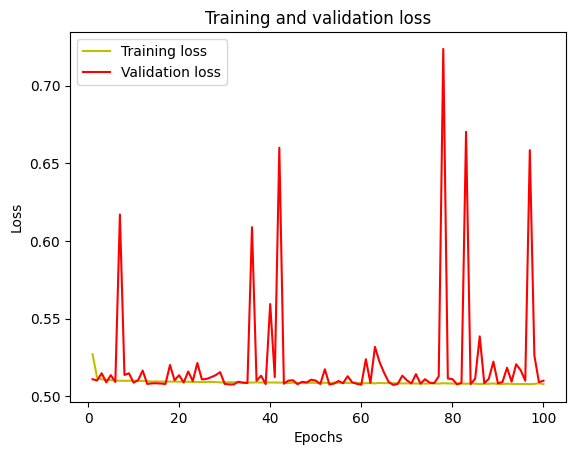

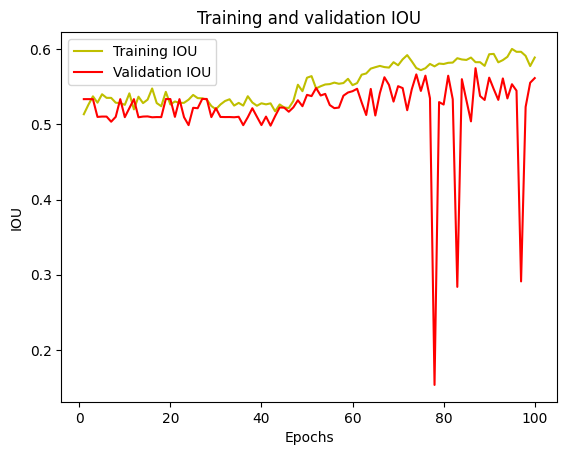

In [ ]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#Load the pretrained model for testing and predictions.
from keras.models import load_model
my_model = load_model('model_data/ISPY1_1221/3D_model_vgg16_100epochs.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly.

In [ ]:
#Predict on the test data
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


In [ ]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

In [ ]:
#Using built in keras function for IoU
#Only works on TF > 2.0
#from keras.metrics import MeanIoU
#from keras.metrics import MeanIoU
#n_classes = 4
#IOU_keras = MeanIoU(num_classes=n_classes)
#IOU_keras.update_state(y_test_argmax, y_pred_argmax)
#print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
print(len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = actual_preprocess_function(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)




In [ ]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

In [ ]:
#Plot individual slices from test predictions for verification
slice = 14
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

Now segment the full volume using the trained model.

In [ ]:
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = nib.load('ISPY1_1002/ISPY1_1002_image.nii.gz').get_fdata()
patches = patchify(large_image, (64, 64, 64), step=64)
print(large_image.shape)
print(patches.shape)

In [ ]:
# Predict each 3D patch
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = actual_preprocess_function(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)



In [ ]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

In [ ]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches,
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

In [ ]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

In [ ]:
print(reconstructed_image.dtype)